<b><center>
<span style="font-size: 24pt; line-height: 1.2">
Machine Learning & Deep Learning Project 1 : Predicting Happiness<br>
</span>
</center></b>
</span><br>
<p>
<i><center>
<span style="font-size: 20pt; line-height: 1.2">
Jino Kwon<br>
</span>
</center></i>

# Objective: Predict World Happiness Rankings 

What makes the citizens of one country more happy than the citizens of other countries?  Do variables measuing perceptions of corruption, GDP, maintaining a healthy lifestyle, or social support associate with a country's happiness ranking?  

Let's use the United Nation's World Happiness Rankings country level data to experiment with models that predict happiness rankings well.


---

**Data**: 2019 World Happiness Survey Rankings [1] + ISO 3166 Country Codes [2] *(The International Standard for country codes and codes for their subdivisions)*

**Features**
*   Country or region
*   GDP per capita
*   Social support
*   Healthy life expectancy
*   Freedom to make life choices
*   Generosity
*   Perceptions of corruption
*   World regions (from *ISO 3166 Country Codes*)

**Target**
*   Happiness_level (Very High = Top 20% and Very Low = Bottom 20%)

**Quick note**: Countries are used in this project as a categorical variable. This variable actually is categorical at the observation level. Suffice it to say, in practice it is not ideal to build a model with a categorical variable such as countries in the World Happiness Report because there are too many categories. This is a rationale for merging this dataset with the ISO 3166 dataset because using world regions instead of countries can significantly reduce the number of categories.

Source:
* [1] https://worldhappiness.report/
* [2] https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv

# Import & Merge & Clean Datasets




In [52]:
! pip install scikit-learn --upgrade
# load newest version of sklearn
# note to myself: this is an important step when collaborating with others

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import seed
seed = 1000
np.random.seed(seed)
import pandas as pd

In [0]:
# Import two datasets
data = pd.read_csv("worldhappiness2019.csv")
regiondata = pd.read_csv("region.csv")

# Merge two datasets
mergedata=pd.merge(data, regiondata, how='left', left_on='Country or region', right_on='name')

# Check for missing values (there won't be any given that I have already cleaned up the region data)
mergedata.loc[pd.isnull(mergedata).iloc[:,9]].to_csv("missing.csv", index=False)

# Clean up final region data
X = mergedata.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'], axis=1)
y = mergedata['Happiness_level']

In [3]:
X.tail()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region
151,0.359,0.711,0.614,0.555,0.217,0.411,Africa
152,0.476,0.885,0.499,0.417,0.276,0.147,Africa
153,0.350,0.517,0.361,0.000,0.158,0.025,Asia
154,0.026,0.000,0.105,0.225,0.235,0.035,Africa
155,0.306,0.575,0.295,0.010,0.202,0.091,Africa


# 1. Explore bivariate results (Using visualizations)

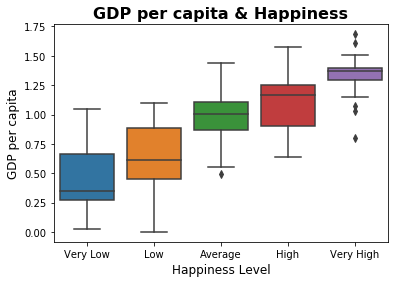

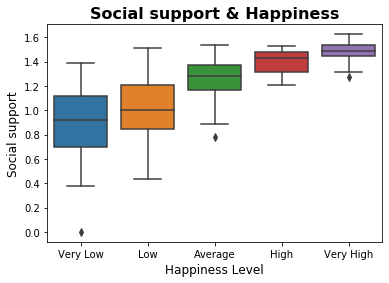

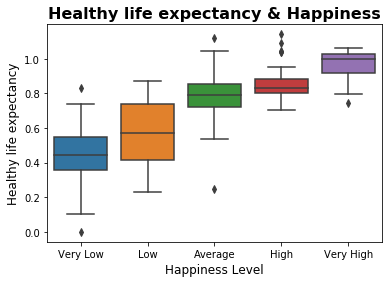

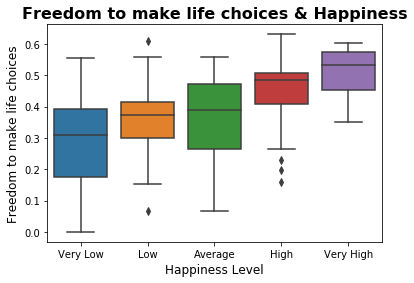

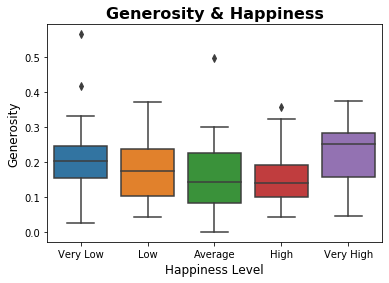

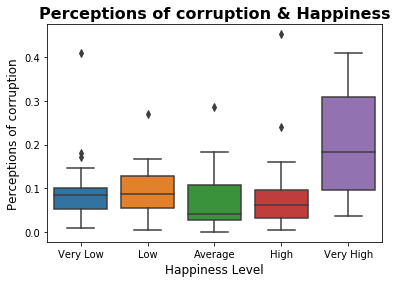

In [0]:
feature = ['GDP per capita','Social support', 'Healthy life expectancy','Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
for f in feature:
  graph = sns.boxplot(x="Happiness_level", y= f, data = mergedata,
            order=["Very Low", "Low", "Average", "High", "Very High"])
  plt.title(f + ' & Happiness', weight='bold', fontsize=16)
  plt.xlabel('Happiness Level', fontsize=12)
  plt.ylabel(f, fontsize=12)
  plt.show()

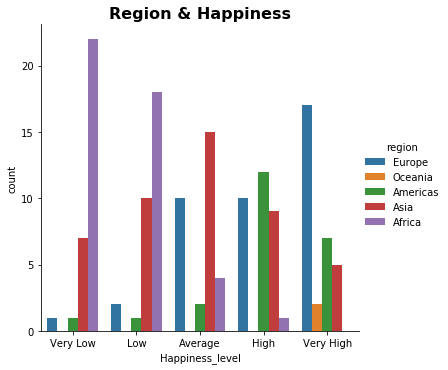

In [0]:
graph1 = sns.catplot(x='Happiness_level', hue="region", kind="count", data = mergedata,
            order=["Very Low", "Low", "Average", "High", "Very High"])
plt.title('Region & Happiness', weight='bold', fontsize=16)
plt.show()

**Observation**: I expected that all these features (except for perceptions of corruption) would have positive correlations with one's happiness level. The data support that people are more likely to be happy when their country has more money(GDP), social support, healthy life expectancy, and freedom to make life choices.

Contrary to my expectation, however, generosity and perceptions of corruption do not seem to have any  correlation with happiness. It is actually interesting that a region with a 'very high' happiness level shows a markedly higher preception of corruption. This could be seen as just a blip in the data, or may provide insights about how features possibly interact with each other. For example, we can see that Europe takes up a huge portion of 'very happy' areas in the graph above. It could be that people in these few European countries may not only enjoy a wealthy, healty life, but also have heightened social awareness that they are more likely to detect corruption in their society. (*Yet, I'd like to note that this is just one possible explanation.*)
# 2. Feature Selection
Let's examine features that predict happiness categories using models that allow for automatic feature selection.
* Preprocess data using Column Transformer and save fit preprocessor to ".pkl" file

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [0]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create the preprocessing pipelines for both numeric and categorical data.
numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

# Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform your preprocessor object
prediction_input_preprocessor = preprocessor.fit(X_train) 

import pickle
pickle.dump(prediction_input_preprocessor.transform(X_train), open( "preprocessor.pkl", "wb" ) )

* SelectFromModel method with Penalized Logistic Regression

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

logreg = SelectFromModel(LogisticRegression()).fit(prediction_input_preprocessor.transform(X_train), y_train)

logreg.get_support()

array([ True,  True,  True,  True, False, False, False,  True, False,
       False, False])

* Feature Importance using ExtraTreesClassifier

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

In [8]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=800,
                              random_state=0)

forest.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))
importances = forest.feature_importances_
importances

array([0.17622523, 0.15332364, 0.17000432, 0.1261836 , 0.10418124,
       0.13103238, 0.05173807, 0.02830761, 0.03172107, 0.02525559,
       0.00202725])

* I used two different models to evaluate features importances. The first model using SelectFromModel didn't select Generosity, Perceptions of Corruption, and regional data. Regional data again showed lower feature importance compared to the other variables.
 
# 3. Prediction models to predict World Happiness
## Model 1: a Neural Network model with Keras (DL Model 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,BatchNormalization
import keras
from keras.optimizers import SGD
import tensorflow as tf
tf.set_random_seed(seed)

Using TensorFlow backend.


In [10]:
# Check shape for keras input:
prediction_input_preprocessor.transform(X_train).shape 
# This is a pretty small dataset for deep learning.
# Always pay attention to the input size when you use keras!

(117, 11)

In [11]:
# Check shape for keras output:

pd.get_dummies(y_train).shape

(117, 5)

In [12]:
model1 = Sequential()
# notice that input_dim is '11' (the size of hot-encoded data)
model1.add(Dense(124, input_dim=11, activation='relu'))
model1.add(Dense(124, activation='relu'))
model1.add(Dense(124, activation='relu'))
model1.add(Dense(124, activation='relu'))
model1.add(Dense(124, activation='relu'))
model1.add(Dense(124, activation='relu'))
# notice the number '5' because we have 5 categories
model1.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
# Remember that we're running this with 'preprocessed, transformed data'
model1.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train),
          batch_size = 60, epochs = 1000)  






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1000





117/117 [==============================] - 0s 3ms/step - loss: 1.6019 - acc: 0.2479
Epoch 2/1000
117/117 [==============================] - 0s 142us/step - loss: 1.5998 - acc: 0.2564
Epoch 3/1000
117/117 [==============================] - 0s 106us/step - loss: 1.5981 - acc: 0.2821
Epoch 4/1000
117/117 [==============================] - 0s 79us/step - loss: 1.5960 - acc: 0.2650
Epoch 5/1000
117/117 [==============================] - 0s 69us/step - loss: 1.5942 - acc: 0.2735
Epoch 6/1000
117/117 [==============================] - 0s 88us/step - loss: 1.5925 - acc: 0.2821
Epoch 7/1000
117/117 [==============================] - 0s 73us/step - loss: 1.5906 - acc: 0.2991
Epoch 8/1000
117/117 [==============================] - 0s 66us/step - loss: 1.5888 - acc: 0.3162
Epoch 9/1000
117/117 [==============================] - 0s 67us/step - loss: 1.5870 - acc: 0.3162
Epoch 10/1

* Evaluate Keras Model using model_eval_metrics(), assign result to modelevalobject.

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

In [0]:
# Now we can extract some evaluative metrics to use for model submission
def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [15]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index = model1.predict_classes(prediction_input_preprocessor.transform(X_test))

#Now lets run some code to get keras to return the label rather than the index...
# get labels from one hot encoded y_train data
labels= pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels, index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels, 1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

['Very High', 'Low', 'Very Low', 'High', 'Low', 'Very Low', 'Average', 'High', 'Average', 'Low', 'Low', 'Low', 'Average', 'Average', 'Average', 'Very High', 'Very Low', 'Low', 'High', 'Average', 'High', 'High', 'Very High', 'Very High', 'Very High', 'Low', 'High', 'Low', 'High', 'Very Low', 'High', 'Very High', 'Average', 'Very High', 'Low', 'Average', 'High', 'Average', 'Low']


In [16]:
# add metrics to submittable object
modelevalobject = model_eval_metrics (y_test, predicted_labels, classification="TRUE")

modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.538462,0.548333,0.575079,0.612424,0,0,0,0


## Model 2: a Neural Network model with Keras (DL Model 2)

In [17]:
model2 = Sequential()
# notice that input_dim is '11' (the size of hot-encoded data)
model2.add(Dense(124, input_dim=11, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(124, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(124, activation='relu'))
model2.add(Dropout(.3))
# notice the number '5' because we have 5 categories
model2.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
# Remember that we're running this with 'preprocessed, transformed data'
model2.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), batch_size = 60, epochs = 500) 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/500
117/117 [==============================] - 0s 2ms/step - loss: 1.6218 - acc: 0.2222
Epoch 2/500
117/117 [==============================] - 0s 81us/step - loss: 1.6297 - acc: 0.2393
Epoch 3/500
117/117 [==============================] - 0s 63us/step - loss: 1.6474 - acc: 0.2137
Epoch 4/500
117/117 [==============================] - 0s 67us/step - loss: 1.6015 - acc: 0.2735
Epoch 5/500
117/117 [==============================] - 0s 67us/step - loss: 1.6186 - acc: 0.2308
Epoch 6/500
117/117 [==============================] - 0s 63us/step - loss: 1.6084 - acc: 0.2393
Epoch 7/500
117/117 [==============================] - 0s 65us/step - loss: 1.5919 - acc: 0.2735
Epoch 8/500
117/117 [==============================] - 0s 69us/step - loss: 1.6185 - acc: 0.1966
Epoch 9/500
117/117 [==============================] - 0s 67us/step - loss: 1.6028 - acc: 0.2308
Epoch 10/500

In [18]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index = model2.predict_classes(prediction_input_preprocessor.transform(X_test))

#Now lets run some code to get keras to return the label rather than the index...
# get labels from one hot encoded y_train data
labels= pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels, index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels, 1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

modelevalobject2 = model_eval_metrics (y_test, predicted_labels, classification="TRUE")
modelevalobject2

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.564103,0.548091,0.56978,0.574242,0,0,0,0


In [21]:
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

model3 = Sequential()
# notice that input_dim is '11' (the size of hot-encoded data)
model3.add(Dense(64, input_dim=11, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# notice the number '5' because we have 5 categories
model3.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
# Remember that we're running this with 'preprocessed, transformed data'
model3.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), batch_size = 60, epochs = 1000) 

Epoch 1/1000
117/117 [==============================] - 1s 5ms/step - loss: 4.9978 - acc: 0.1966
Epoch 2/1000
117/117 [==============================] - 0s 60us/step - loss: 4.9928 - acc: 0.2222
Epoch 3/1000
117/117 [==============================] - 0s 60us/step - loss: 4.9880 - acc: 0.2479
Epoch 4/1000
117/117 [==============================] - 0s 59us/step - loss: 4.9833 - acc: 0.2906
Epoch 5/1000
117/117 [==============================] - 0s 71us/step - loss: 4.9785 - acc: 0.3248
Epoch 6/1000
117/117 [==============================] - 0s 69us/step - loss: 4.9738 - acc: 0.3590
Epoch 7/1000
117/117 [==============================] - 0s 60us/step - loss: 4.9692 - acc: 0.3590
Epoch 8/1000
117/117 [==============================] - 0s 62us/step - loss: 4.9645 - acc: 0.3761
Epoch 9/1000
117/117 [==============================] - 0s 66us/step - loss: 4.9600 - acc: 0.3761
Epoch 10/1000
117/117 [==============================] - 0s 65us/step - loss: 4.9558 - acc: 0.3761
Epoch 11/1000
117/11

In [22]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index = model3.predict_classes(prediction_input_preprocessor.transform(X_test))

#Now lets run some code to get keras to return the label rather than the index...
# get labels from one hot encoded y_train data
labels= pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels, index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels, 1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

modelevalobject3 = model_eval_metrics (y_test, predicted_labels, classification="TRUE")
modelevalobject3

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.589744,0.597243,0.607576,0.637576,0,0,0,0


# Save keras model to onnx file.  We will use this file to make predictions within a production ready scalable REST API.

In [0]:
# Load libraries for onnx model conversion (keras to onnx)
# Companies such as  Microsoft and Facebook start to use onnx files quite exnstensively.
# Onnx files are very good for productions. Light-weight, running fast, very portable.
! pip3 install keras2onnx
! pip3 install onnxruntime

## Model 4: Random Forest Classifier (ML Model 1)

In [0]:
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [95]:
rfc_pipe = make_pipeline(RandomForestClassifier(random_state=42))

rfc_param_grid = {'randomforestclassifier__n_estimators': [300, 1000, 1500],
                  'randomforestclassifier__max_depth': [6, 7, 8, 10]}
model4 = GridSearchCV(rfc_pipe, rfc_param_grid, cv=kfold).fit(prediction_input_preprocessor.transform(X_train), y_train)

print("MODEL 4 : RANDOM FOREST CLASSIFIER")
print("Accuracy: {:.5f}".format(model4.score(prediction_input_preprocessor.transform(X_test), y_test)))
print("Best Parameter: {}".format(model4.best_params_))

MODEL 4 : RANDOM FOREST CLASSIFIER
Accuracy: 0.43590
Best Parameter: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 1500}


## Model 5: Support Vector Classifier (ML Model 2)

In [96]:
from sklearn.svm import SVC

param_grid = {'C': [5, 10, 50, 100], 'gamma': [0.0001, 0.0005, 0.001, 0.005]}
model5 = GridSearchCV(SVC(), param_grid, cv=kfold).fit(prediction_input_preprocessor.transform(X_train), y_train)
print("MODEL 5 : SUPPORT VECTOR MACHINE")
print("Accuracy: {:.5f}".format(model4.score(prediction_input_preprocessor.transform(X_test), y_test)))
print("Best Parameters: {}".format(model4.best_params_))

MODEL 5 : SUPPORT VECTOR MACHINE
Accuracy: 0.43590
Best Parameters: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 1500}


## Results
* The best model was Model 3: a deep learning model with 6 hidden layers with 64 nodes for each and epochs set to 1000. For each layer, I also applied a few regularization techniques such as kernel_regularizer (applied to weights) set to 0.01 and bias_regularizer (applied to bias unit) also set to 0.01. Even though the model had many layers and thus was at risk of overfitting, I believe the regularizers helped handle this issue, which in turn rendered high prediction performance; for instance, Model 1 also had 6 hidden layers even with a greater number of nodes ('128'), but Model 3 outperformed Model 1.

* My best model was submitted to the leader board for the World Happiness AI Model Share competition.

## Submit the best model to the leader board for the World Happiness AI Model Share competition.

In [23]:
#install aimodelshare library
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.2.tar.gz?raw=true

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.2.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.2-cp36-none-any.whl size=5375 sha256=86e35a72a0c310eecbb3239ffdef613cf8f03fc6ae85a26da6465f5f1ad71c2f
  Stored in directory: /root/.cache/pip/wheels/31/8d/ac/09cb6ef7374ec79e02843c347195e5478144006b11def6799a
Successfully built aimodelshare


In [0]:
# Save sklearn modle to pkl file
import pickle
pickle.dump(model3, open( "model3.pkl", "wb" ) )

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://btuvanmi55.execute-api.us-east-1.amazonaws.com/prod/m"
username = "xxx"
password = "xxx"

region='us-east-1'
model_filepath="model3.pkl"   
preprocessor_filepath="preprocessor.pkl"
preprocessor="TRUE"

trainingdata=X_train

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.
aws_key_password_region = pickle.load( open( "worldhappiness_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [26]:
# Submit new model
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata=trainingdata,preprocessor_filepath=preprocessor_filepath,preprocessor=preprocessor)

"model3.pkl" has been loaded to version 121 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [27]:
# Check leaderboard
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

LEADERBOARD RANKINGS:


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression
1,0.717949,0.717857,0.717857,0.727778,0,0,0,0,3scman,85,2.333333,1.0
2,0.717949,0.713796,0.719444,0.725000,0,0,0,0,3scman,70,2.333333,1.0
3,0.666667,0.675975,0.754286,0.700952,0,0,0,0,dhoward97,69,2.666667,1.0
4,0.692308,0.693333,0.700397,0.702778,0,0,0,0,3scman,62,4.000000,1.0
5,0.641026,0.642381,0.743590,0.682273,0,0,0,0,SUN-Wenjun,83,4.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.333333,0.337698,0.385556,0.322222,0,0,0,0,username2,2,47.333333,1.0
106,0.333333,0.337698,0.385556,0.322222,0,0,0,0,username2,3,47.333333,1.0
105,0.333333,0.337698,0.385556,0.322222,0,0,0,0,username2,6,47.333333,1.0
108,0.333333,0.336015,0.354048,0.325000,0,0,0,0,raquel904,102,48.000000,1.0
